# Labor Market Analysis

In [268]:
# The standard stuff
import pandas as pd
import numpy as np
import math

# The world's most amazing NLP library.  Thank you Matthew Honnibal.  Remind me to give you a hug when I see you.
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# Your classic clustering 
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ooooooooh - now THIS should be fun.
import umap
import hdbscan

# And make it look pretty!
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# Load SpaCy's large embedding model
nlp = spacy.load('en_core_web_lg')

### Load data and show columns

In [3]:
df = pd.read_csv('data\\online-job-postings.csv')
print(df.columns.values)

['jobpost' 'date' 'Title' 'Company' 'AnnouncementCode' 'Term' 'Eligibility'
 'Audience' 'StartDate' 'Duration' 'Location' 'JobDescription'
 'JobRequirment' 'RequiredQual' 'Salary' 'ApplicationP' 'OpeningDate'
 'Deadline' 'Notes' 'AboutC' 'Attach' 'Year' 'Month' 'IT']


In [4]:
df.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


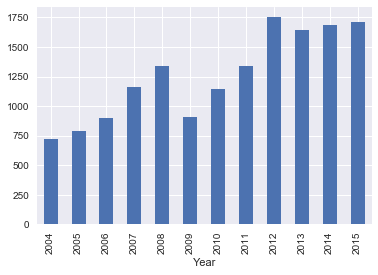

In [275]:
%matplotlib inline
df.groupby('Year')['Title'].count().plot(kind='bar')

### Remove empty cells in target columns

In [5]:
df = df.dropna(subset=['Title', 'JobDescription', 'Year', 'jobpost'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15091 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             15091 non-null object
date                15091 non-null object
Title               15091 non-null object
Company             15091 non-null object
AnnouncementCode    970 non-null object
Term                6695 non-null object
Eligibility         3615 non-null object
Audience            459 non-null object
StartDate           7932 non-null object
Duration            9050 non-null object
Location            15079 non-null object
JobDescription      15091 non-null object
JobRequirment       13129 non-null object
RequiredQual        15082 non-null object
Salary              8104 non-null object
ApplicationP        15091 non-null object
OpeningDate         14609 non-null object
Deadline            15073 non-null object
Notes               1685 non-null object
AboutC              10162 non-null object
Attach              948 non-null object
Year                1

### Clean up titles

In [8]:
def cleanTitles(sentence):
    newsent = ''.join(c for c in sentence if c not in punctuation)
    return ' '.join([x for x in newsent.split() if x.lower() not in STOP_WORDS])

df['cleanTitle'] = df.apply(lambda row: cleanTitles(row['Title']), axis=1)

In [9]:
df['cleanTitle'].head()

0               Chief Financial Officer
2                   Country Coordinator
3                        BCC Specialist
5                            Saleswoman
6    Chief Accountant Finance Assistant
Name: cleanTitle, dtype: object

### Clean up Descriptions

#### Remove description stopwords

In [11]:
def removeStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in STOP_WORDS])

df['cleandesc'] = df.apply(lambda row: removeStopWords(row['JobDescription']), axis=1)

In [12]:
df['cleandesc'][0]

"AMERIA Investment Consulting Company seeking Chief Financial Officer. position manages company's fiscal administrative functions, provides highly responsible technically complex staff assistance Executive Director. work performed requires high level technical proficiency financial management investment management, management, supervisory, administrative skills."

#### Count most popular words
In this section, we'll find low-signal across all job postings, such as "job" and "performance", and manually add them to the list.  This is because there are some high-signal words at the top, such as "software".

In [13]:
alldescs = ' '.join(df['cleandesc'].values)
alldescs = ' '.join(alldescs.split())

wordcount = {}

for i in alldescs.lower().split():
    if i in wordcount: 
        wordcount[i] += 1
    else:
        wordcount[i] = 1
        
sorted_wordcount = sorted(wordcount.items(), key=lambda x: x[1], reverse=True)

In [14]:
sorted_wordcount

[('responsible', 4711),
 ('looking', 4290),
 ('incumbent', 3840),
 ('position', 3717),
 ('development', 3538),
 ('seeking', 3015),
 ('project', 2809),
 ('work', 2793),
 ('software', 2136),
 ('support', 2044),
 ('armenia', 1814),
 ('team', 1811),
 ('manager', 1713),
 ('management', 1712),
 ('-', 1712),
 ('candidate', 1681),
 ('llc', 1645),
 ('implementation', 1491),
 ('activities', 1454),
 ('company', 1424),
 ('financial', 1380),
 ('provide', 1322),
 ('technical', 1303),
 ('supervision', 1301),
 ('business', 1288),
 ('office', 1264),
 ('sales', 1259),
 ('specialist', 1246),
 ('qualified', 1238),
 ('program', 1224),
 ('senior', 1197),
 ('international', 1145),
 ('services', 1107),
 ('cjsc', 1102),
 ('highly', 1085),
 ('experienced', 1059),
 ('working', 1039),
 ('motivated', 1011),
 ('design', 996),
 ('web', 987),
 ('marketing', 976),
 ('quality', 959),
 ('engineer', 946),
 ('he/', 904),
 ('ensure', 892),
 ('developer', 882),
 ('armenian', 876),
 ('administrative', 866),
 ("company's", 85

From this list, we'll select the words that may help in clearing up the clustering.

In [15]:
custom_stopwords = [
    'responsible', 
    'looking', 
    'incumbent',
    'position',
    'seeking',
    'work',
    'support',
    'team',
    'candidate',
    'llc',
    'company',
    'activities',
    'ensure', 
    'armenian', 
    'candidates', 
    '-', 
    'armenia']

def removeCustomStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in custom_stopwords])

df['newcleandesc'] = df.apply(lambda row: removeStopWords(row['cleandesc']), axis=1)
df = df.reset_index(drop=True)


### Clean up jobposts

#### Remove jobposts stopwords

In [17]:
def removeStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in STOP_WORDS])

df['cleanjob'] = df.apply(lambda row: removeStopWords(row['jobpost']), axis=1)

In [19]:
df['cleanjob'][0]

"AMERIA Investment Consulting Company JOB TITLE: Chief Financial Officer POSITION LOCATION: Yerevan, Armenia JOB DESCRIPTION: AMERIA Investment Consulting Company seeking Chief Financial Officer. position manages company's fiscal administrative functions, provides highly responsible technically complex staff assistance Executive Director. work performed requires high level technical proficiency financial management investment management, management, supervisory, administrative skills. JOB RESPONSIBILITIES: - Supervises financial management administrative staff, including assigning responsibilities, reviewing employees' work processes products, counseling employees, giving performance evaluations, recommending disciplinary action; - Serves member management team participating strategic operational planning company; - Directs oversees company's financial management activities, including establishing monitoring internal controls, managing cash investments, managing investment portfolio co

#### Count most popular words
In this section, we'll find low-signal across all job postings, such as "job" and "performance", and manually add them to the list.  This is because there are some high-signal words at the top, such as "software".

In [20]:
alldescs = ' '.join(df['cleanjob'].values)
alldescs = ' '.join(alldescs.split())

wordcount = {}

for i in alldescs.lower().split():
    if i in wordcount: 
        wordcount[i] += 1
    else:
        wordcount[i] = 1
        
sorted_wordcount = sorted(wordcount.items(), key=lambda x: x[1], reverse=True)

In [21]:
sorted_wordcount

[('-', 248544),
 ('job', 60179),
 ('application', 50868),
 ('mention', 32885),
 ('website', 30858),
 ('knowledge', 30649),
 ('experience', 27766),
 ('work', 25779),
 ('armenia', 25150),
 ('ability', 19547),
 ('letter', 18779),
 ('development', 18023),
 ('required', 17834),
 ('center', 17312),
 ('clearly', 16438),
 ('career', 16357),
 ('follow', 16309),
 ('opportunities', 16190),
 ('candidates', 15973),
 ('opportunity', 15880),
 ('available', 15773),
 ('place', 15432),
 ('free', 15411),
 ('qualifications:', 15372),
 ('yerevan,', 15273),
 ('organization,', 15236),
 ('learned', 15199),
 ('posting', 15134),
 ('thanks.', 15107),
 ('url', 15100),
 ('procedures:', 15092),
 ('title:', 15086),
 ('description:', 15081),
 ('www.careercenter.am,', 15081),
 ('deadline:', 15079),
 ('----------------------------------', 15075),
 ('location:', 15065),
 ('career-related', 14937),
 ('opening', 14905),
 ('link.', 14852),
 ('www.careercenter.am', 14823),
 ('"post', 14815),
 ('announcement"', 14814),
 ('en

In [22]:
custom_stopwords = [
    '-',
    'job', 
    'application',
    'website',
    'ability',
    'responsible', 
    'looking', 
    'incumbent',
    'position',
    'seeking',
    'work',
    'support',
    'team',
    'candidate',
    'llc',
    'company',
    'activities',
    'ensure', 
    'armenian', 
    'candidates', 
    '-', 
    'armenia']

def removeCustomStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in custom_stopwords])

df['newcleanjob'] = df.apply(lambda row: removeStopWords(row['cleanjob']), axis=1)
df = df.reset_index(drop=True)


### Generate vectors for titles, descriptions, and job posts
We are going to create 3 vectors for each job posting: An average word embedding for the title itself, one for the basic description, and because we have a bunch of one-liners, we'll also add the entire post.

In [24]:
vectorsTitles        = []
vectorsDescriptions  = []
vectorsJobPosts      = []
counter = 0 

for index, row in df.iterrows():    
    vectorsTitles.append(nlp(row['cleanTitle']).vector)    
    vectorsDescriptions.append(nlp(row['newcleandesc']).vector)
    vectorsJobPosts.append(nlp(row['newcleanjob']).vector)
    
    # show progress every 1000 - maybe go grab some coffee.
    counter = counter + 1
    if counter % 1000 == 0:
        print(counter)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [258]:
numclusters   = range(1, 20)
kmeans        = [KMeans(n_clusters=i) for i in numclusters]


kTitles       = [kmeans[i].fit(vectorsTitles) for i in range(len(kmeans))]
scoreTitles   = [kTitles[i].score(vectorsTitles) for i in range(len(kmeans))]
print('scoreTitles done.')
clusterTitles = [kTitles[i].labels_ for i in range(len(kmeans))]
print('clusterTitles done.')

kDescriptions       = [kmeans[i].fit(vectorsDescriptions) for i in range(len(kmeans))]
scoreDescriptions   = [kDescriptions[i].score(vectorsDescriptions) for i in range(len(kmeans))]
print('scoreDescriptions done.')
clusterDescriptions = [kDescriptions[i].labels_ for i in range(len(kmeans))]
print('clusterDescriptions done.')

kJobPosts       = [kmeans[i].fit(vectorsJobPosts) for i in range(len(kmeans))]
scoreJobPosts   = [kJobPosts[i].score(vectorsJobPosts) for i in range(len(kmeans))]
print('scoreJobPosts done.')
clusterJobPosts = [kJobPosts[i].labels_ for i in range(len(kmeans))]
print('clusterJobPosts done.')

scoreTitles done.
clusterTitles done.
scoreDescriptions done.
clusterDescriptions done.
scoreJobPosts done.
clusterJobPosts done.


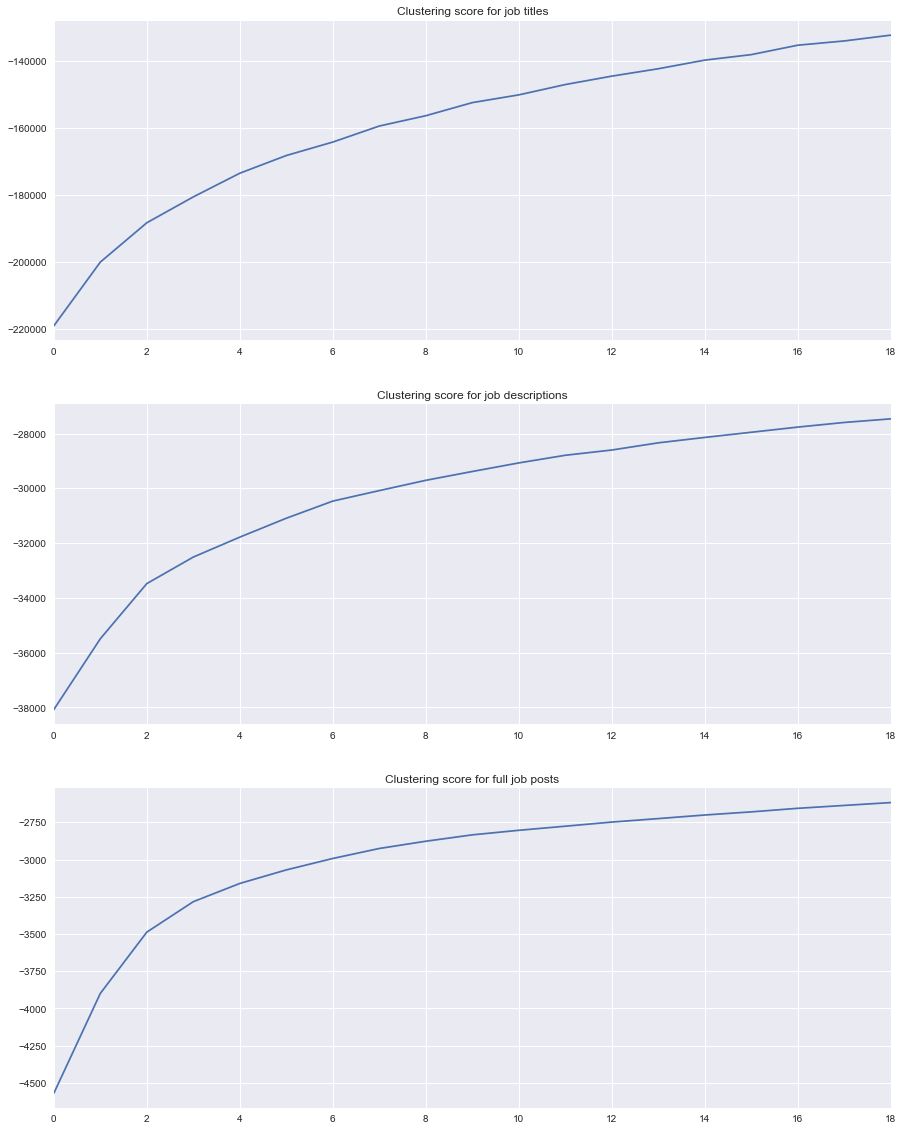

In [263]:
 %matplotlib inline

sns.set()
fig, axs = plt.subplots(nrows=3, figsize=(15,20))
pd.Series([i for i in scoreTitles]      ).plot(ax=axs[0])
pd.Series([i for i in scoreDescriptions]).plot(ax=axs[1])
pd.Series([i for i in scoreJobPosts]    ).plot(ax=axs[2])
axs[0].set_title('Clustering score for job titles')
axs[1].set_title('Clustering score for job descriptions')
axs[2].set_title('Clustering score for full job posts')

# Find silhouette scores for each vector

In [264]:
silhouetteTitles   = [silhouette_score(vectorsTitles, kmeans[i + 1].fit_predict(vectorsTitles)) for i in range(len(kmeans) - 1)]
print('silhouetteTitles done.')

silhouetteDescriptions   = [silhouette_score(vectorsDescriptions, kmeans[i + 1].fit_predict(vectorsDescriptions)) for i in range(len(kmeans) - 1)]
print('silhouetteDescriptions done.')

silhouetteJobPosts   = [silhouette_score(vectorsJobPosts, kmeans[i + 1].fit_predict(vectorsJobPosts)) for i in range(len(kmeans) - 1)]
print('silhouetteJobPosts done.')

silhouetteTitles done.
silhouetteDescriptions done.
silhouetteJobPosts done.


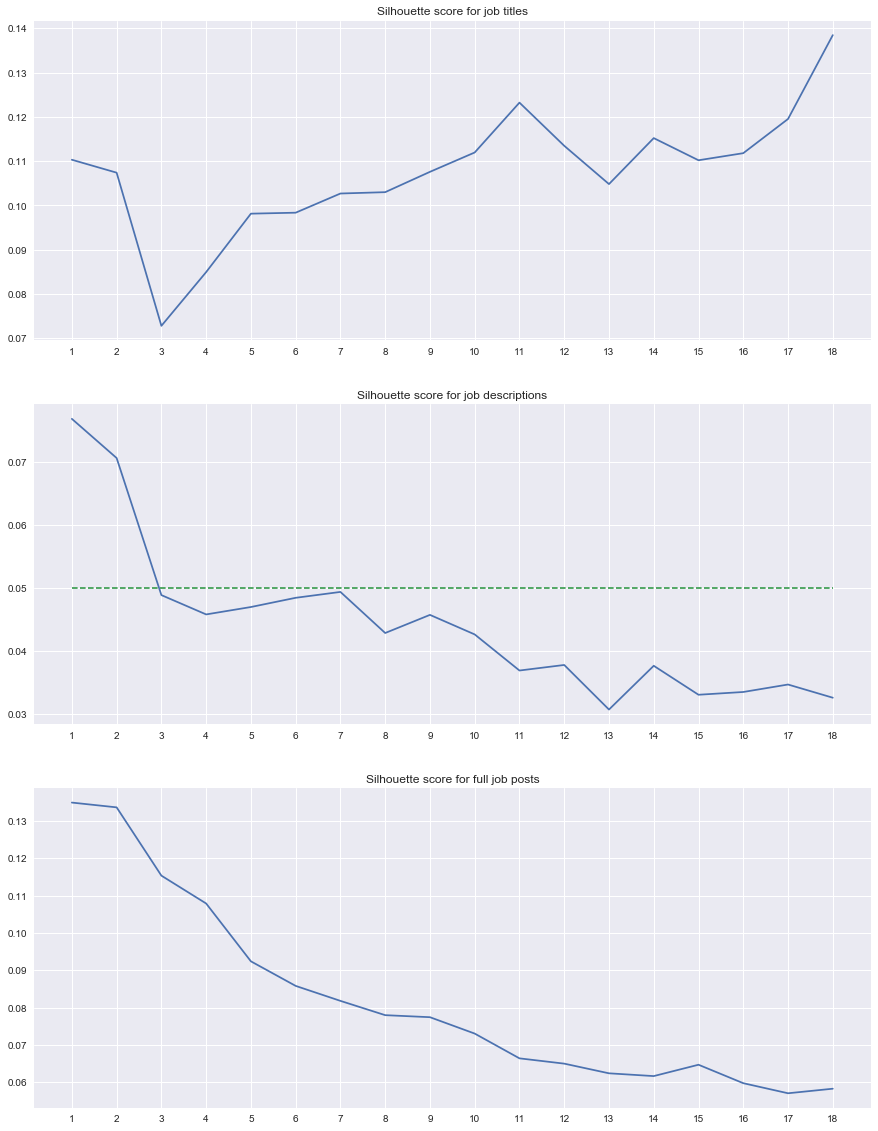

In [269]:

silhouetteLabels = [k+1 for (k,v) in enumerate(silhouetteTitles)]
fig, axs = plt.subplots(nrows=3, figsize=(15,20))
loc = plticker.MultipleLocator(base=1.0)

axs[0].plot(silhouetteLabels, silhouetteTitles)
axs[0].xaxis.set_major_locator(loc)
axs[0].set_title('Silhouette score for job titles')

axs[1].plot(silhouetteLabels, silhouetteDescriptions)
axs[1].xaxis.set_major_locator(loc)
axs[1].set_title('Silhouette score for job descriptions')

axs[2].plot(silhouetteLabels, silhouetteJobPosts)
axs[2].xaxis.set_major_locator(loc)
axs[2].set_title('Silhouette score for full job posts')

axs[1].plot([1, 18], [0.05, 0.05], linestyle='dashed', lw=2)


### Fire up UMAP and HDBSCAN
Woah, Nelly!  Now we're going to play with the fun stuff.  

In [219]:
# Ideal parameters I've found.  These are the values to experiment with.

n_neighbors=40
min_cluster_size=100

In [220]:
# Concatenate arrays 
newVectors = np.concatenate([vectorsTitles, vectorsDescriptions, vectorsJobPosts], axis=1)
np.shape(newVectors)

(15091, 900)

In [221]:
reducer = umap.UMAP(n_neighbors=n_neighbors)
embeddings = reducer.fit_transform(newVectors)

In [222]:
hdb20 = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
scoreTitles = hdb20.fit(embeddings)
print("hdb done")
clusterTitles = scoreTitles.labels_

hdb done


In [223]:
print(clusterTitles[0:500])

[21 -1 -1 -1  4 -1 -1 25 25 -1  7 12 19 -1 25 -1 25  4 25  8 25  8 -1 -1 -1
 -1 -1 -1 -1 -1 -1  5 -1  9 -1 -1  9  1 25 -1 20 -1 -1 -1 -1 -1 -1 -1 12 -1
 -1 24 -1  2 25 -1  1 -1  7 12 -1 -1 14 -1 11 25 -1 -1 21 -1 -1 -1 -1  2  9
 -1 11 12  9 12 25 11  7 -1 12 25 25  7 -1 -1 -1 -1 -1 -1 25  7 -1 21 -1 -1
 19 -1 14 -1 -1 25 25 -1 25  8 25 25 -1 -1 -1 -1 -1 -1 25 12 -1 -1 25  8 -1
 25 -1 -1 -1 -1  7 -1 25 -1 22 -1 25 16  9 -1 12  9 -1  7 12 -1 -1  8 -1 -1
  8 24 24  7 25 -1 -1  7  7  7 25  7  1 -1 24 12 -1 -1 25 -1  7 -1 -1  8 13
 -1  8  8  1 -1 -1 13 13 13 13 16 16 18  0 -1 16 25 -1 -1 -1  4 -1 -1 -1 15
 25 -1 -1  6  7 -1  8 -1 25 -1 -1 -1  4 -1 -1 -1 -1 18 25 25 -1 25 20 25  7
  7  7 25 -1 -1 25 25 -1 -1 -1 -1 27 -1 11 25 -1 25 25 18 -1  8 25 25 25  2
 -1 -1 25  0 -1 -1 25 -1 12 25 -1 -1 -1 -1  7 -1 -1 -1  7 -1 27 25 -1 27 -1
 -1 16 -1 -1 -1 -1 -1 -1 25 -1 -1 25 -1 25 14 -1  1 -1 -1  8 -1  1 25 25  7
  7 -1  7 25 -1 25 -1 -1 -1  7 -1  7 -1 25 -1 25 12 -1 25  4  7  7  7  7  6
 -1  7 -1  6

In [224]:
clusterTitles.max()

27

In [ ]:
print("Unclustered values: ", list(clusterTitles).count(-1))
print("Total Values: ", len(list(clusterTitles)))
print("Data usage: {0:.2f}".format(list(clusterTitles).count(-1)) / len(list(clusterTitles)))

In [228]:
#clusterTitles
hddf = df
hddf['cluster'] = clusterTitles
hddf[hddf['cluster'] == 2]['cleanTitle']

53                 Software Developers
73                  Software Developer
249                 Software Developer
349                 Software developer
410                 Software Developer
970      Software Developer Programmer
1016                Software Developer
1075              Software Programmers
1183                Software Developer
1255                Software Developer
1339                Software Developer
1363                Software Developer
1383                Software Developer
1438                Software Developer
1478                Software Developer
1509                Software Developer
1575               Software Developers
1646                Software Developer
1672                Software Developer
1679               Software Developers
1700                Software Developer
1935                Software Developer
1964     Software Developer Programmer
1970                Software Developer
1983                Software Developer
2037                Softw

In [229]:
numClusters = clusterTitles.max()
hddf.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Attach,Year,Month,IT,cleanTitle,cleandesc,newcleandesc,cleanjob,newcleanjob,cluster
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2004,1,False,Chief Financial Officer,AMERIA Investment Consulting Company seeking C...,AMERIA Investment Consulting Company seeking C...,AMERIA Investment Consulting Company JOB TITLE...,AMERIA Investment Consulting Company JOB TITLE...,21
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,2004,1,False,Country Coordinator,Public outreach strengthening growing network ...,Public outreach strengthening growing network ...,Caucasus Environmental NGO Network (CENN) JOB ...,Caucasus Environmental NGO Network (CENN) JOB ...,-1
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2004,1,False,BCC Specialist,LEAD (Local Enhancement Development Health) BC...,LEAD (Local Enhancement Development Health) BC...,Manoff Group JOB TITLE: BCC Specialist POSITIO...,Manoff Group JOB TITLE: BCC Specialist POSITIO...,-1
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...","Jan 10, 2004",Saleswoman,"Boutique ""Appollo""",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2004,1,False,Saleswoman,Saleswoman sell menswear accessories.,Saleswoman sell menswear accessories.,"Boutique ""Appollo"" JOB TITLE: Saleswoman POSIT...","Boutique ""Appollo"" JOB TITLE: Saleswoman POSIT...",-1
4,OSI Assistance Foundation - Armenian Branch Of...,"Jan 11, 2004",Chief Accountant/ Finance Assistant,OSI Assistance Foundation - Armenian Branch Of...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2004,1,False,Chief Accountant Finance Assistant,Armenian Branch Office Open Society Institute ...,Armenian Branch Office Open Society Institute ...,OSI Assistance Foundation - Armenian Branch Of...,OSI Assistance Foundation - Armenian Branch Of...,4


### Show most popular words for each cluster

#### Count each word, per cluster

In [259]:
wordcount = {}
sorted_wordcount = {}
for i in range(numClusters):
    titles = hddf[hddf['cluster'] == i]["cleanTitle"].values
    titles = ' '.join(' '.join(titles).split())
    wordcount[i] = {}
    for j in titles.lower().split():
        if j in wordcount[i]: 
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
        
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)
    print("Cluster: " + str(i))
    print(sorted_wordcount[i][0:5])
    print('---')


Cluster: 0
[('lawyer', 125), ('advocate', 3), ('attorney', 1)]
---
Cluster: 1
[('accountant', 259), ('auditor', 22), ('outsourcing', 4), ('cheef', 1), ('bookkeeper', 1)]
---
Cluster: 2
[('software', 130), ('developer', 125), ('developers', 4), ('programmer', 4), ('programmers', 1)]
---
Cluster: 3
[('developer', 166), ('android', 70), ('ios', 64), ('senior', 48), ('application', 32)]
---
Cluster: 4
[('accountant', 233), ('chief', 225), ('assistant', 29), ('deputy', 26), ('engineer', 11)]
---
Cluster: 5
[('medical', 236), ('representative', 222), ('yerevan', 19), ('armenia', 8), ('sales', 3)]
---
Cluster: 6
[('developer', 412), ('java', 250), ('php', 169), ('senior', 145), ('software', 80)]
---
Cluster: 7
[('developer', 930), ('senior', 298), ('software', 298), ('web', 289), ('c', 280)]
---
Cluster: 8
[('preseller', 15), ('merchandiser', 12), ('methodologist', 6), ('3d', 5), ('secretaryreferent', 5)]
---
Cluster: 9
[('language', 140), ('translator', 116), ('english', 106), ('interpreter'

#### Find the top 5 words (to get a sense of the cluster's contents)

In [233]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords[key] = ''
    for newkey, j in sorted_wordcount[key][0:4]:
        print(newkey + ' / ', end='')
        topwords[key] = topwords[key] + newkey + ' / '
    print()

Cluster 0: lawyer / advocate / attorney / 
Cluster 1: accountant / auditor / outsourcing / cheef / 
Cluster 2: software / developer / developers / programmer / 
Cluster 3: developer / android / ios / senior / 
Cluster 4: accountant / chief / assistant / deputy / 
Cluster 5: medical / representative / yerevan / armenia / 
Cluster 6: developer / java / php / senior / 
Cluster 7: developer / senior / software / web / 
Cluster 8: preseller / merchandiser / methodologist / 3d / 
Cluster 9: language / translator / english / interpreter / 
Cluster 10: hr / manager / assistant / generalist / 
Cluster 11: manager / project / construction / senior / 
Cluster 12: administrative / assistant / office / manager / 
Cluster 13: quality / assurance / engineer / tester / 
Cluster 14: assistant / executive / director / ceo / 
Cluster 15: administrator / system / network / systems / 
Cluster 16: engineer / software / senior / support / 
Cluster 17: qa / engineer / senior / manager / 
Cluster 18: analyst /

#### Find top word (for legend)

In [254]:
firsttopword = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    firsttopword[key] = [k for k in sorted_wordcount[key][0]][0]
    print(firsttopword[key])

Cluster 0: lawyer
Cluster 1: accountant
Cluster 2: software
Cluster 3: developer
Cluster 4: accountant
Cluster 5: medical
Cluster 6: developer
Cluster 7: developer
Cluster 8: preseller
Cluster 9: language
Cluster 10: hr
Cluster 11: manager
Cluster 12: administrative
Cluster 13: quality
Cluster 14: assistant
Cluster 15: administrator
Cluster 16: engineer
Cluster 17: qa
Cluster 18: analyst
Cluster 19: marketing
Cluster 20: legal
Cluster 21: finance
Cluster 22: manager
Cluster 23: manager
Cluster 24: agent
Cluster 25: specialist
Cluster 26: service


In [234]:
#fig, ax = plt.subplots()
datecount = {}
for i in range(numClusters):
    dates = hddf[hddf['cluster'] == i]['Year'].values
    datecount[i] = {}
    for jobdate in dates:
        if jobdate in datecount[i]: 
            datecount[i][jobdate] += 1
        else:
            datecount[i][jobdate] = 1

datedf = pd.DataFrame(datecount)

# fill in NaN's
datedf.fillna(value=0, inplace=True)

### Normalize the view to see the trends

In [236]:
x = datedf.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normdf = pd.DataFrame(x_scaled)


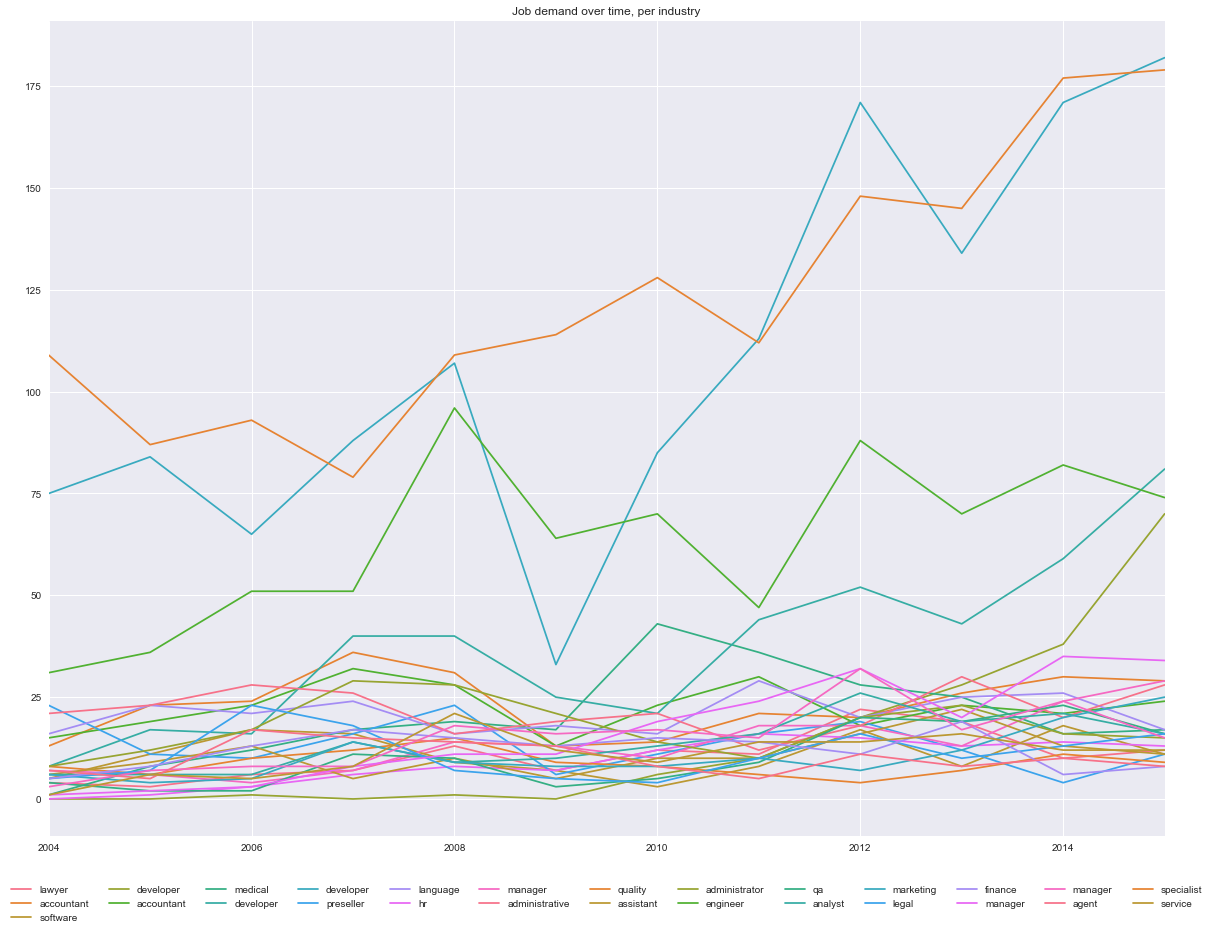

In [279]:
%matplotlib inline
fig, axs = plt.subplots(nrows=1, figsize=(20,15))

sns.set_palette("husl", 12)  # oooh, pretty

datedf.plot(ax=axs)
#normdf.plot(ax=axs[1])
axs.set_title('Job demand over time, per industry')
#axs[1].set_title('Normalized job demand over time, per industry')

L=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=int(numClusters/2))
for i in range(numClusters):
    L.get_texts()[i].set_text(firsttopword[i])

#### Find top industries (Top values and fastest growth)